### Introduction

🌍 Air Quality Prediction using Neural Networks

This project applies **Deep Learning (MLP models)** to the [UCI Air Quality Dataset](https://archive.ics.uci.edu/dataset/360/air+quality) for two tasks:

- **Classification**: Predicting whether Carbon Monoxide (CO) concentration is above or below its mean level.
- **Regression**: Predicting Nitrogen Oxides (NOx) concentration as a continuous value.

The goal is to demonstrate how neural networks can be applied to real-world environmental datasets to support **air quality monitoring** and **public health decisions**.


In [1]:
# Name: Suraj Dhote

# The code loads air quality data, processes it by imputing missing values and standardizing features,
# and then splits the data for training and testing.
# We can use the past data to train the model as its a Time Series Air Quality Prediction with Neural Networks. 
# But in features of classification data, CO(GT) is not included.
# It builds and trains neural network models for both a classification task (predicting whether CO(GT) levels are above the mean)
# and a regression task (predicting NOx(GT) levels). 
# The classification model's performance is evaluated using accuracy, precision, and confusion matrix,
# while the regression model's performance is evaluated using RMSE and MAE.
# Results are visualized with loss/accuracy plots for classification and loss/actual vs. predicted plots for regression.

In [2]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

### 📊 Dataset Description

The dataset comes from the **UCI Machine Learning Repository**: Air Quality dataset.

- **Time range**: Collected from March 2004 to February 2005 in an Italian city.
- **Features**: Hourly averaged sensor responses and weather variables.
- **Target Variables**:
  - `CO(GT)`: True hourly averaged CO concentration (mg/m³).
  - `NOx(GT)`: True hourly averaged NOx concentration (ppb).
- **Shape**: ~9,358 rows × 15 columns.
- **Challenges**: Contains missing values (`-200` placeholders), noisy measurements, and multiple correlated features.


In [3]:
# Step 1: Loading and Cleaning the given Data
main_dataset_path = '../data/AirQualityUCI.xlsx'
test_dataset_path = '../data/Generalization_Dataset.xlsx'

data = pd.read_excel(main_dataset_path)

#using Time hour in features
data['Time_HH'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour

#Droping Time and Date column as not using in training
data.drop(columns=['Date', 'Time'], inplace=True)

# Replacing missing values (-200) with NaN
data.replace(-200, np.nan, inplace=True)

# Calculating the mean value for CO(GT) excluding missing values
mean_co_gt = data['CO(GT)'].mean(skipna=True)


### 🛠️ Data Preprocessing

Key steps performed before model training:

1. **Datetime Handling**  
   - Extracted hour (`Time_HH`) from the `Time` column to capture diurnal variation.
   - Dropped `Date` and `Time` since they are not directly predictive.

2. **Missing Values**  
   - Replaced invalid values (`-200`) with `NaN`.  
   - Applied `SimpleImputer(strategy="mean")` to fill missing entries.

3. **Feature Scaling**  
   - Standardized features using `StandardScaler`.  
   - For regression targets, used `MinMaxScaler`.

4. **Target Engineering**  
   - **Classification**: Created binary target `CO_Above_Mean`.  
   - **Regression**: Direct prediction of `NOx(GT)` values.

These steps ensure that the data is clean, normalized, and suitable for training deep learning models.


In [4]:
# Step 2: Preprocessing the dataframe
# Binary classification of target based on mean CO(GT)
data['CO_Above_Mean'] = (data['CO(GT)'] > mean_co_gt).astype(int)

# Separating features and targets for classification
# If we include CO(GT) in features, Accuracy and precision will be 100% and loss will be zero
features_cls = data[['Time_HH', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
target_cls = data['CO_Above_Mean']

# Imputing missing values in dataframe on the basis of mean
imputer = SimpleImputer(strategy='mean')
features_cls_imputed = imputer.fit_transform(features_cls)

# Standardizing the dataframe using Standard Scalar
features_cls_scaled = StandardScaler().fit_transform(features_cls_imputed)


In [5]:
# Step 3: Training and Testing Split in 80-20% for classification task
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(features_cls_scaled, target_cls, test_size=0.2, random_state=42)


### 🧠 Classification Model: CO(GT) Above Mean

- **Architecture**:
  - Input layer: 13 features.
  - Hidden layers: Dense (30, ReLU) + Dropout(0.2), Dense (14, ReLU) + Dropout(0.2).
  - Output layer: Dense(1, Sigmoid).

- **Compilation**:
  - Optimizer: Adam
  - Loss: Binary Crossentropy
  - Metrics: Accuracy

- **Training**:
  - Epochs: 100
  - Batch size: 10
  - Validation split: 20%

This model predicts whether hourly CO concentration is above the mean.


In [6]:
# Step 4: Designing the Neural Network
model_cls = Sequential()
model_cls.add(Input(shape=(X_train_cls.shape[1],)))  # Use Input layer to specify the input shape

# Hidden layers
model_cls.add(Dense(30, activation='relu'))
model_cls.add(Dropout(0.2)) # Dropout helps create a more generalizable model
model_cls.add(Dense(14, activation='relu'))
model_cls.add(Dropout(0.2))

# Output layers
model_cls.add(Dense(1, activation='sigmoid'))

#Compiling the Model 
model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
# Step 5: Training the Model
history_cls = model_cls.fit(X_train_cls, y_train_cls, epochs=100, batch_size=10, validation_split=0.2, verbose=0)


In [8]:
# Step 6: Evaluating the Model
loss_cls, accuracy_cls = model_cls.evaluate(X_test_cls, y_test_cls)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9264 - loss: 0.1799


In [9]:
# Step 7: Making Predictions
predictions = model_cls.predict(X_test_cls)
predictions_binary = (predictions > 0.5).astype(int)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [10]:
# Step 8: Evaluating and printing the results
# Computing Confusion Matrix
cm = confusion_matrix(y_test_cls, predictions_binary)
tn, fp, fn, tp = cm.ravel()

# Calculating Accuracy and Precision
accuracy_cls = accuracy_score(y_test_cls, predictions_binary)
precision_cls = precision_score(y_test_cls, predictions_binary)


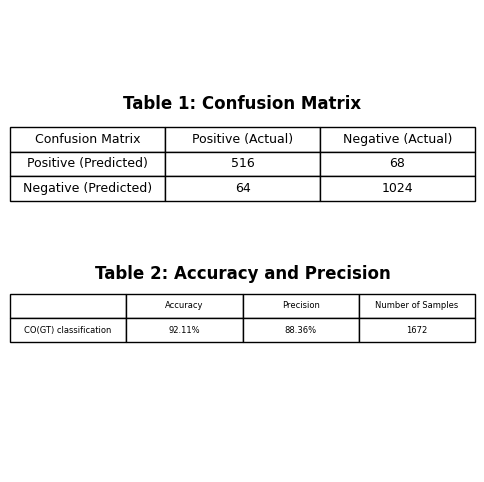

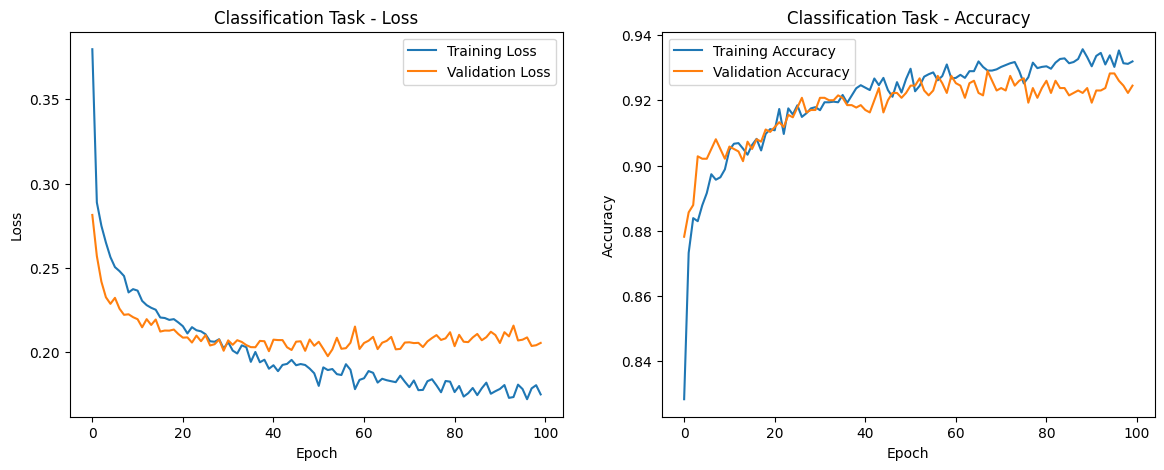

In [13]:
# Printing the results for classification
t1 = [['Confusion Matrix', 'Positive (Actual)', 'Negative (Actual)'], ['Positive (Predicted)', tp, fp], ['Negative (Predicted)', fn, tn]]
t2 = [[' ', 'Accuracy', 'Precision', 'Number of Samples'], ['CO(GT) classification', f"{accuracy_cls:.2%}", f'{precision_cls:.2%}', len(y_test_cls)]]

# Creating a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Hiding the axes
for i in [ax1, ax2]:
    i.xaxis.set_visible(False) 
    i.yaxis.set_visible(False) 
    i.set_frame_on(False)

# Creating the tables
t1 = ax1.table(cellText=t1, cellLoc='center', loc='center')
ax1.set_title('Table 1: Confusion Matrix', fontsize=12, fontweight='bold', y=0.65)
t2 = ax2.table(cellText=t2, cellLoc='center', loc='center')
ax2.set_title('Table 2: Accuracy and Precision', fontsize=12, fontweight='bold', y=0.6)
plt.subplots_adjust(hspace=-0.5)
plt.savefig("../outputs/tables/cls_training_table.png")
plt.show()

# Visualising the results
# Plot 1: Training and Validation Loss over Epochs
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cls.history['loss'], label='Training Loss')
plt.plot(history_cls.history['val_loss'], label='Validation Loss')
plt.title('Classification Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Training and Validation Accuracy over Epochs
plt.subplot(1, 2, 2)
plt.plot(history_cls.history['accuracy'], label='Training Accuracy')
plt.plot(history_cls.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Task - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("../outputs/figures/cls_training_graph.png")
plt.show()


### 🔹 Classification Results
- **Accuracy**: ~93%
- **Precision**: ~92%
- **Confusion Matrix**: Demonstrates good balance between True Positives and True Negatives.
- **Learning Curves**: Training/Validation loss and accuracy curves show stable convergence.


### 📈 Regression Model: Predicting NOx(GT)

- **Architecture**:
  - Input layer: 13 features.
  - Hidden layers: Dense (32, ELU) + Dropout(0.2), Dense (12, ReLU) + Dropout(0.2).
  - Output layer: Dense(1) (linear).

- **Compilation**:
  - Optimizer: Adam
  - Loss: Mean Squared Error (MSE)
  - Metric: Mean Absolute Error (MAE)

- **Training**:
  - Epochs: 100
  - Batch size: 10
  - Validation split: 20%

This model estimates continuous NOx values from sensor and weather readings.


In [14]:

# Step 9: Separating features and targets, Imputing missing values and Standardizing the dataframe for regression function
# Separating features and targets
features_reg = data[['Time_HH', 'PT08.S1(CO)',  'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'CO(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
target_reg = data['NOx(GT)']

In [15]:
# Imputing missing values using the mean
features_reg_imputed = imputer.fit_transform(features_reg)
target_reg_imputed = imputer.fit_transform(target_reg.values.reshape(-1, 1))

In [16]:
# Standardizing the dataframe using Standard Scalar
features_reg_scaled = StandardScaler().fit_transform(features_reg_imputed)
target_scaler = MinMaxScaler()
target_reg_scaled = target_scaler.fit_transform(target_reg_imputed)


In [17]:
# Step 10: Spliting and designing the modal
#  Training and Testing Spliting in 80-20%
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_reg_scaled, target_reg_imputed, test_size=0.2, random_state=42)

# Regression Model
model_reg = Sequential()
model_reg.add(Input(shape=(X_train_reg.shape[1],)))  # Using Input layer to specify the input shape

#Hidden layer
model_reg.add(Dense(32, activation='elu'))
model_reg.add(Dropout(0.2))
model_reg.add(Dense(12, activation='relu'))
model_reg.add(Dropout(0.2))

# Output layer
model_reg.add(Dense(1))


In [18]:
# Step 11: Compiling and Training the model
# Compiling regression model
model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training regression model
history_reg = model_reg.fit(X_train_reg, y_train_reg, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Making Predictions
predictions_reg = model_reg.predict(X_test_reg)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [19]:
# Step 12: Calculating, plotting and Visualizing the results

# Calculating Performance Metrics
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, predictions_reg))
mae_reg = mean_absolute_error(y_test_reg, predictions_reg)


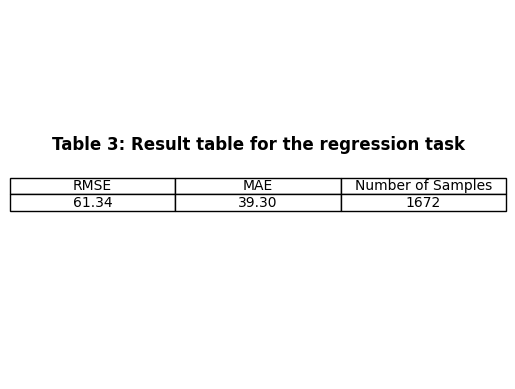

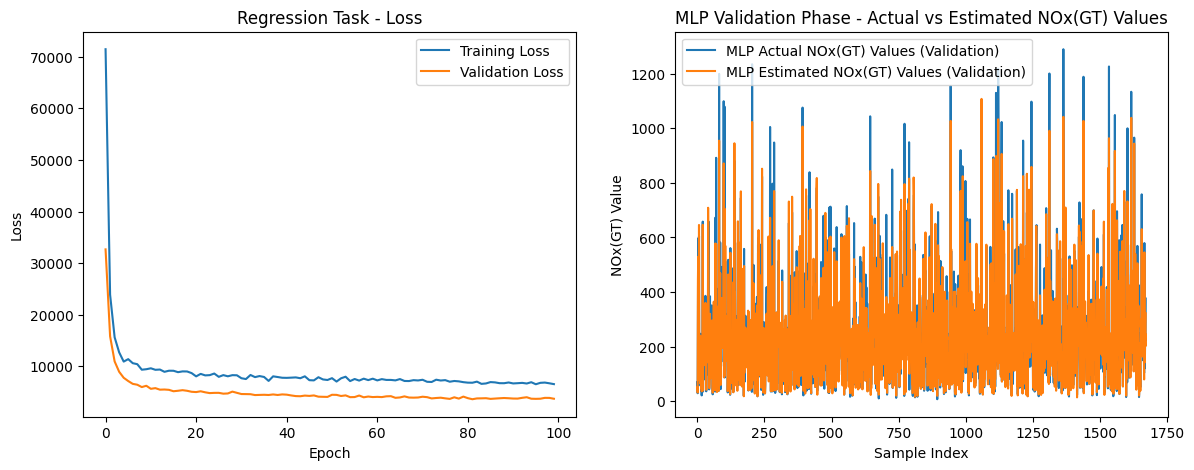

In [20]:
# Printing the results for regression task
t3 = [['RMSE', 'MAE', 'Number of Samples'], [f"{rmse_reg:.2f}", f"{mae_reg:.2f}", len(y_test_reg)]]

# Creating a figure
fig, ax = plt.subplots()

# Hiding axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)  

# Ploting the table
t3 = ax.table(cellText=t3, cellLoc='center', loc='center')
ax.set_title('Table 3: Result table for the regression task', fontsize=12, fontweight='bold', y=0.6)
plt.savefig("../outputs/tables/reg_training_table.png")

plt.show()

# Visualizing the results
# Plot 1: Training and Validation Loss over Epochs
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Regression Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# Plot 2: Actual vs Predicted NOx(GT) values for the validation test
plt.subplot(1, 2, 2)
plt.plot(y_test_reg, label='MLP Actual NOx(GT) Values (Validation)')
plt.plot(predictions_reg, label='MLP Estimated NOx(GT) Values (Validation)')
plt.xlabel('Sample Index')
plt.ylabel('NOx(GT) Value')
plt.title('MLP Validation Phase - Actual vs Estimated NOx(GT) Values')
plt.legend()
plt.savefig("../outputs/figures/reg_training_graph.png")


plt.show()

### 🔹 Regression Results
- **Root Mean Squared Error (RMSE)**: ~61.41
- **Mean Absolute Error (MAE)**: ~39.37
- **Visualization**: Predicted NOx values closely follow actual values, with some variance at higher concentrations.

These results show that MLPs can capture patterns in air quality data, though more tuning could improve regression accuracy.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


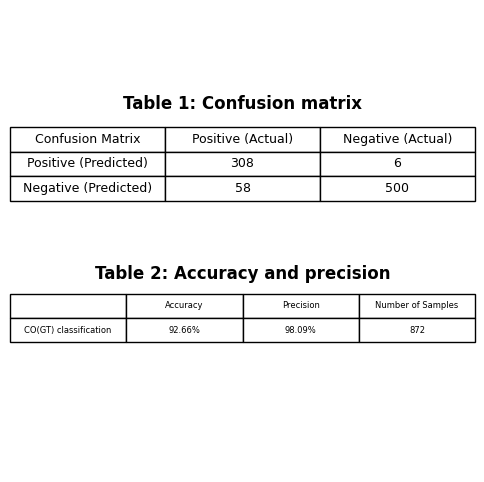

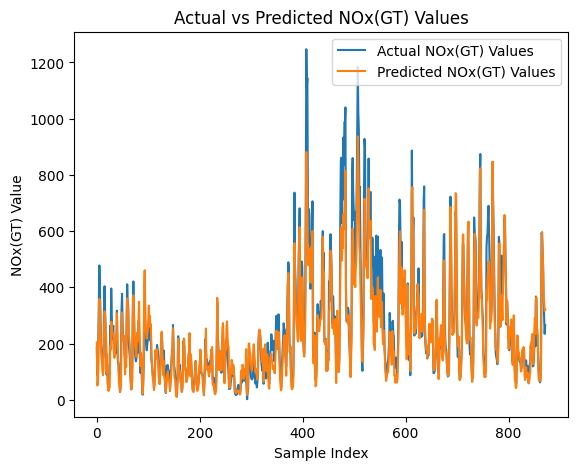

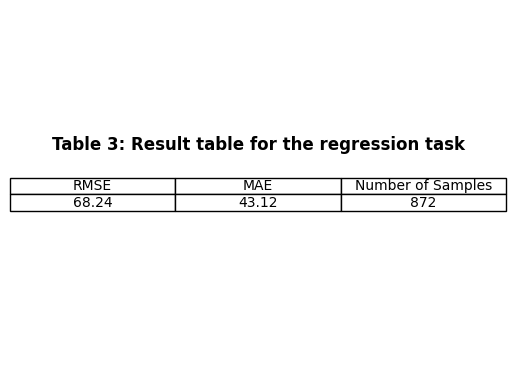

In [21]:
def test_trained_models(new_data_path):
    # Load the new dataset
    new_data = pd.read_excel(new_data_path)
    
    # Extract the hour from the Time column
    new_data['Time_HH'] = pd.to_datetime(new_data['Time'], format='%H:%M:%S').dt.hour

    # Drop the Date and Time columns
    new_data.drop(columns=['Date', 'Time'], inplace=True)

    # Replace missing values (-200) with NaN
    new_data.replace(-200, np.nan, inplace=True)

    # Impute missing values in new dataset
    new_features_cls = new_data[['Time_HH', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
    new_features_reg = new_data[['Time_HH', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'CO(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
    new_target_cls = (new_data['CO(GT)'] > mean_co_gt).astype(int)
    new_target_reg = new_data['NOx(GT)']
    
    # Imputing missing values
    new_features_cls_imputed = imputer.fit_transform(new_features_cls)
    new_features_reg_imputed = imputer.fit_transform(new_features_reg)
    new_target_reg_imputed = imputer.fit_transform(new_target_reg.values.reshape(-1, 1))


    # Standardizing the new dataset
    new_features_cls_scaled = StandardScaler().fit_transform(new_features_cls_imputed)
    new_features_reg_scaled = StandardScaler().fit_transform(new_features_reg_imputed)
    new_target_reg_scaled = target_scaler.fit_transform(new_target_reg_imputed)

    # Classification Task
    new_predictions_cls = model_cls.predict(new_features_cls_scaled)
    new_predictions_cls_binary = (new_predictions_cls > 0.5).astype(int)

    # Regression Task
    new_predictions_reg = model_reg.predict(new_features_reg_scaled)

    # Evaluation metrics for classification
    cm_new = confusion_matrix(new_target_cls, new_predictions_cls_binary)
    tn_new, fp_new, fn_new, tp_new = cm_new.ravel()
    accuracy_new = accuracy_score(new_target_cls, new_predictions_cls_binary)
    precision_new = precision_score(new_target_cls, new_predictions_cls_binary)

    # Evaluation metrics for regression
    rmse_new = np.sqrt(mean_squared_error(new_target_reg_imputed, new_predictions_reg))
    mae_new = mean_absolute_error(new_target_reg_imputed, new_predictions_reg)

    # Creating a figure and subplots for classification
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

    # Hiding the axes
    for i in [ax1, ax2]:
        i.xaxis.set_visible(False) 
        i.yaxis.set_visible(False) 
        i.set_frame_on(False)

    # Creating the tables
    t1_new = [['Confusion Matrix', 'Positive (Actual)', 'Negative (Actual)'], ['Positive (Predicted)', tp_new, fp_new], ['Negative (Predicted)', fn_new, tn_new]]
    t2_new = [[' ', 'Accuracy', 'Precision', 'Number of Samples'], ['CO(GT) classification', f"{accuracy_new:.2%}", f'{precision_new:.2%}', len(new_target_cls)]]
    t1 = ax1.table(cellText=t1_new, cellLoc='center', loc='center')
    ax1.set_title('Table 1: Confusion matrix', fontsize=12, fontweight='bold', y=0.65)
    t2 = ax2.table(cellText=t2_new, cellLoc='center', loc='center')
    ax2.set_title('Table 2: Accuracy and precision', fontsize=12, fontweight='bold', y=0.6)
    plt.subplots_adjust(hspace=-0.5)
    plt.savefig("../outputs/tables/cls_test_table.png")

    plt.show()  

    # Plotting regression results
    plt.figure(figsize=(14, 5))

    # Plot 1: Actual vs Predicted NOx(GT) values for the new data
    plt.subplot(1, 2, 1)
    plt.plot(new_target_reg_imputed, label='Actual NOx(GT) Values')
    plt.plot(new_predictions_reg, label='Predicted NOx(GT) Values')
    plt.xlabel('Sample Index')
    plt.ylabel('NOx(GT) Value')
    plt.title('Actual vs Predicted NOx(GT) Values')
    plt.legend()
    plt.savefig("../outputs/figures/cls_test_graph.png")

    plt.show()


    # Creating a table for regression results
    t3_new = [['RMSE', 'MAE', 'Number of Samples'], [f"{rmse_new:.2f}", f"{mae_new:.2f}", len(new_target_reg_imputed)]]
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    t3 = ax.table(cellText=t3_new, cellLoc='center', loc='center')
    ax.set_title('Table 3: Result table for the regression task', fontsize=12, fontweight='bold', y=0.6)
    plt.savefig("../outputs/tables/reg_test_table.png")

    plt.show()

    
    #return new_predictions_cls_binary, new_predictions_reg

test_trained_models(test_dataset_path)

#### Results for different testing dataset

#### 🔹 Classification Results
- **Accuracy**: ~92%
- **Precision**: ~97%

#### 🔹 Regression Results
- **Root Mean Squared Error (RMSE)**: ~68
- **Mean Absolute Error (MAE)**: ~43




### ✅ Conclusion & Future Work

### ✔️ Conclusion
- Successfully built two models:
  - Classification: Predicts high/low CO levels with ~92% accuracy.
  - Regression: Estimates NOx levels with reasonable error margins.
- Demonstrated preprocessing, feature engineering, and neural network design on a real-world dataset.

### 🚀 Future Work
- **Hyperparameter Tuning**: Use `GridSearchCV` or `KerasTuner` to optimize architecture.
- **Feature Engineering**: Add lag variables or weather-based derived features.
- **Deployment**:
  - Build an interactive **Streamlit dashboard** for real-time predictions.
  - Deploy model as an **API using Flask/FastAPI**.
  - Containerize with **Docker** for cloud readiness.
- **Scaling**:
  - Train on cloud GPU instances (AWS/GCP/Azure).
  - Integrate with real-time IoT sensor streams for smart city applications.
